This notebook is going to clean up the sympy work to get the voltage and current equations.

Once this is cleaned up, I can modify to correctly handle the three phase quantities.

- TODO: concatenate current and voltages into single array
- TODO: how do I handle the line-line line-neutral transformations correctly?
    - reread section of Mevey on line-line vs line-neutral stuff
- TODO: handle case where peak battery or phase current can't be reached

Notes

- I_c V_c looks like about I_b V_b / sqrt(3) in the VESC data

In [1]:
import sys
sys.path.append('../ev_data')
import ev as evd

import sympy 
sympy.init_printing()

def define_equations():
    global Ib, Ic, Vb, Vc, Rm, k, omega, Rb, Voc, Imm, Ibm, torque
    Ib = sympy.symbols('I_b', positive=True)           # battery current during motoring
    Ic = sympy.symbols('I_c', positive=True)           # motor current
    Vb = sympy.symbols('V_b', positive=True)           # battery voltage
    Vc = sympy.symbols('V_c', positive=True)           # motor voltage line to line (should be line phase?)
    Rm = sympy.symbols('R_m', positive=True)           # single phase motor resistance
    k = sympy.symbols('k', positive=True)              # line to line voltage constant
    omega = sympy.symbols('omega', positive=True)      # rotor angular velocity
    Rb = sympy.symbols('R_b', positive=True)           # battery internal resistance
    Voc = sympy.symbols('V_oc', positive=True)         # battery open circuit voltage
    Imm = sympy.symbols('I_mm', positive=True)         # controller maximum current
    Ibm = sympy.symbols('I_bm', positive=True)         # battery maximum current
    torque = sympy.symbols('tau')                      # motor torque


    power_eq = sympy.Eq(Vb * Ib, Vc * Ic * 3 / 2)                    # controller energy balance
    power_eq = sympy.Eq(Vb * Ib, Vc * Ic)                           # controller energy balance
    # reducing k by sqrt(2) makes a good fit but I'm expecting sqrt(3) from line to line models
    controller_loop = sympy.Eq(Vc, Ic * Rm + k * omega / sympy.sqrt(2))              # controller side voltage loop
    controller_loop = sympy.Eq(Vc, Ic * Rm + k * omega)              # controller side voltage loop
    battery_loop = sympy.Eq(Voc, Ib * Rb + Vb)                       # battery side voltage loop
    # set controller current to max for first regime solution
    regime_1_eq = sympy.Eq(Ic, Imm)  
    # TODO: should Ib = Ibm regime be here?
    regime_2_eq = sympy.Eq(Ib, Ibm)
    # set battery and peak motor voltages equal for last regime
    #regime_3_eq = sympy.Eq(Vb / sympy.sqrt(3), Vc)
    regime_3_eq = sympy.Eq(Vb , Vc)
    #regime_3_eq = sympy.Eq(Ib, Ic)
    
    return power_eq, controller_loop, battery_loop, regime_1_eq, regime_2_eq, regime_3_eq


power_eq, controller_loop, battery_loop, regime_1_eq, regime_2_eq, regime_3_eq = define_equations()
#simple_eq = sympy.Eq(Vc, Ic * Rm + k * omega)
#torque_eq = sympy.Eq(torque, k * Ic) # this needs correction factor for three phase

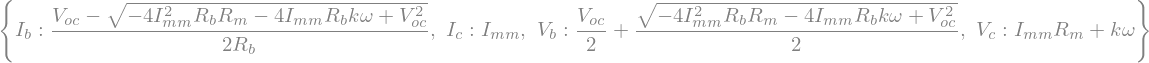

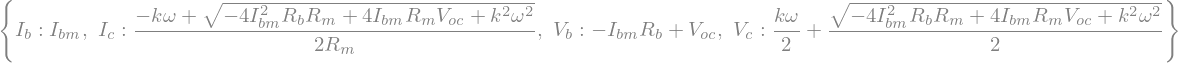

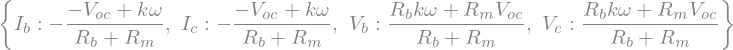

In [2]:
def solve_equations(power_eq, controller_loop, battery_loop, regime_1_eq, regime_2_eq, regime_3_eq):
    # solve for phase current limited regime
    phase_limit = sympy.solve([power_eq, battery_loop, controller_loop, regime_1_eq], exclude=[Rb, Rm, k, Imm, Voc])[0]
    battery_limit = sympy.solve([power_eq, battery_loop, controller_loop, regime_2_eq], exclude=[Rb, Rm, k, Ibm, Voc])[0]
    duty_limit = sympy.solve([power_eq, battery_loop, controller_loop, regime_3_eq], exclude=[Rb, Rm, k, Voc])[0]
    return phase_limit, battery_limit, duty_limit

def display_equations(phase_limit, battery_limit, duty_limit):
    from IPython.display import display
    display(phase_limit)
    display(battery_limit)
    display(duty_limit)

phase_limit, battery_limit, duty_limit = solve_equations(power_eq, controller_loop, battery_loop, regime_1_eq, regime_2_eq, regime_3_eq)
display_equations(phase_limit, battery_limit, duty_limit)

In [3]:
ev_system = {Rb: 0.141, Voc:58, Imm: 100, Ibm:65, Rm: 0.075, k:1.0}

# solve for crossover frequency from phase current to battery current limited

def calculate_crossover_frequencies(phase_limit, battery_limit, duty_limit, ev_system): 
    crossover_1_2 = sympy.solve(sympy.Eq(Ibm, phase_limit[Ib]), omega)[0]
    omega_1_2 = crossover_1_2.evalf(subs=ev_system)
    crossover_2_3 = sympy.solve(sympy.Eq(battery_limit[Ic], duty_limit[Ic]), omega)[0]
    omega_2_3 = crossover_2_3.evalf(subs=ev_system)
    crossover_3 = sympy.solve(sympy.Eq(0, duty_limit[Ic]), omega)[0]
    omega_3 = crossover_3.evalf(subs=ev_system)
    assert 0 < omega_1_2 < omega_2_3 < omega_3
    return omega_1_2, omega_2_3, omega_3

omega_1_2, omega_2_3, omega_3 = calculate_crossover_frequencies(phase_limit, battery_limit, duty_limit, ev_system)

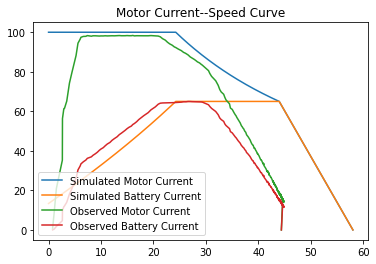

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def generate_currents(ev_system):
    omega_1_2, omega_2_3, omega_3 = calculate_crossover_frequencies(phase_limit, battery_limit, duty_limit, ev_system)
    
    regime_1_omega = np.linspace(0, float(omega_1_2), 100, endpoint=False)
    regime_2_omega = np.linspace(float(omega_1_2), float(omega_2_3), 100, endpoint=False)
    regime_3_omega = np.linspace(float(omega_2_3), float(omega_3), 100)

    Ib_1 = list(map(sympy.lambdify(omega, phase_limit[Ib].subs(ev_system)), regime_1_omega))     # phase limited battery current
    Ic_1 = list(map(sympy.lambdify(omega, phase_limit[Ic].subs(ev_system)), regime_1_omega))
    Ib_2 = list(map(sympy.lambdify(omega, battery_limit[Ib].subs(ev_system)), regime_2_omega))
    Ic_2 = list(map(sympy.lambdify(omega, battery_limit[Ic].subs(ev_system)), regime_2_omega))   # battery limited phase current
    Ic_3 = list(map(sympy.lambdify(omega, duty_limit[Ib].subs(ev_system)), regime_3_omega))
    Ib_3 = list(map(sympy.lambdify(omega, duty_limit[Ic].subs(ev_system)), regime_3_omega))
    Ib_values = np.hstack((np.array(Ib_1), np.array(Ib_2), np.array(Ib_3)))
    Ic_values = np.hstack((np.array(Ic_1), np.array(Ic_2), np.array(Ic_3)))
    omega_values = np.hstack((regime_1_omega, regime_2_omega, regime_3_omega))
    
    return omega_values, Ib_values, Ic_values

omega_values, Ib_values, Ic_values = generate_currents(ev_system)    
plt.plot(omega_values, Ic_values, label='Simulated Motor Current')
plt.plot(omega_values, Ib_values, label='Simulated Battery Current')    

# overlay observed data
data = evd.vesc_csv_to_df('data.csv')
data = evd.pull_throttle_region(data)
data['rad_per_sec'] = evd.rpm_to_radpsec(data, pole_pairs=23)
plt.plot(data['rad_per_sec'], data['current_motor'], label='Observed Motor Current')
plt.plot(data['rad_per_sec'], data['current_in'], label='Observed Battery Current')
plt.legend()
plt.title('Motor Current--Speed Curve')
plt.show()

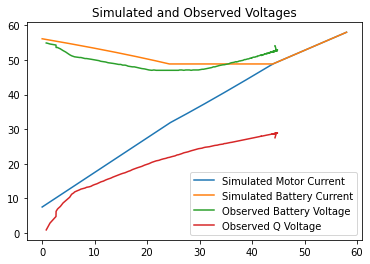

In [5]:
def generate_voltages(ev_system):
    omega_1_2, omega_2_3, omega_3 = calculate_crossover_frequencies(phase_limit, battery_limit, duty_limit, ev_system)
    
    regime_1_omega = np.linspace(0, float(omega_1_2), 100, endpoint=False)
    regime_2_omega = np.linspace(float(omega_1_2), float(omega_2_3), 100, endpoint=False)
    regime_3_omega = np.linspace(float(omega_2_3), float(omega_3), 100)

    Vb_1 = list(map(sympy.lambdify(omega, phase_limit[Vb].subs(ev_system)), regime_1_omega))   # phase limited battery current
    Vc_1 = list(map(sympy.lambdify(omega, phase_limit[Vc].subs(ev_system)), regime_1_omega))
    Vb_2 = list(map(sympy.lambdify(omega, battery_limit[Vb].subs(ev_system)), regime_2_omega))
    Vc_2 = list(map(sympy.lambdify(omega, battery_limit[Vc].subs(ev_system)), regime_2_omega))   # battery limited phase current
    Vc_3 = list(map(sympy.lambdify(omega, duty_limit[Vb].subs(ev_system)), regime_3_omega))
    Vb_3 = list(map(sympy.lambdify(omega, duty_limit[Vc].subs(ev_system)), regime_3_omega))

    Vb_values = np.hstack((np.array(Vb_1), np.array(Vb_2), np.array(Vb_3)))
    Vc_values = np.hstack((np.array(Vc_1), np.array(Vc_2), np.array(Vc_3)))
    omega_values = np.hstack((regime_1_omega, regime_2_omega, regime_3_omega))
    
    return omega_values, Vb_values, Vc_values

omega_values, Vb_values, Vc_values = generate_voltages(ev_system)    
plt.plot(omega_values, Vc_values, label='Simulated Motor Current')
plt.plot(omega_values, Vb_values, label='Simulated Battery Current')    



plt.title('Simulated and Observed Voltages')

# overlay observed data
data = evd.vesc_csv_to_df('data.csv')
data = evd.pull_throttle_region(data)
data['rad_per_sec'] = evd.rpm_to_radpsec(data, pole_pairs=23)
plt.plot(data['rad_per_sec'], data['input_voltage'], label='Observed Battery Voltage')
plt.plot(data['rad_per_sec'], data['q_axis_voltage'], label='Observed Q Voltage')
plt.legend()
plt.show()